## Iniciando Extração de Características 

In [1]:
import pandas as pd
import numpy as np
import os

PATH = os.path.abspath('../../')

## Carregando dados

In [2]:
import pickle

with open(PATH + '/data/ecg_generated_seizure.pkl', 'rb') as handle:
    seizure = pickle.load(handle)

with open(PATH + '/data/ecg_normal.pkl', 'rb') as handle:
    normal = pickle.load(handle)


## Funções para Extração

In [9]:
from math import log, e
from joblib import Parallel, delayed
from scipy.fftpack import fft

def entropy(labels, base=None):
    n_labels = len(labels)
    
    if n_labels <= 1: return 0
    
    value, counts = np.unique(labels, return_counts=True)
    probs = counts / n_labels
    n_classes = np.count_nonzero(probs)
    
    if n_classes <= 1: return 0
        
    ent = 0.
    
    base = e if base is None else base
    
    for i in probs:
        ent -= i * log(i, base)
    return ent

def mean_fft(signal):
    X = fft(signal)
    return np.mean(np.abs(X))

def max_fft(signal):
    X = fft(signal)
    return np.amax(np.abs(X))


def get_features(signals, func):
    return [func(signal) for signal in signals]

def to_vector(array):
    aux = []
    for row in array:
        for item in row:
            aux.append(item)
    return aux

def pipeline(data,func):
    return to_vector(Parallel(n_jobs=-1)(delayed(get_features)(item['heart_beats'],func) for item in data))


In [4]:
from scipy import fft, ifft


def frequency_sepectrum(x, sf):
    x = x - np.average(x)  
    n = len(x)
    k = arange(n)
    tarr = n/float(sf)

    frqarr = k / float(tarr)  # two sides frequency range
    frqarr = frqarr[range(n // 2)]  # one side frequency range
    x = fft(x) / n  # fft computing and normalization
    x = x[range(n // 2)]

    return frqarr, abs(x)

    

In [10]:
from scipy.stats import skew, kurtosis


seizure_var = pipeline(seizure,np.var)
seizure_ske = pipeline(seizure,skew)
seizure_kur = pipeline(seizure,kurtosis)
seizure_ent = pipeline(seizure,entropy)
seizure_mean_fft = pipeline(seizure,mean_fft)
seizure_max_fft = pipeline(seizure,max_fft)



normal_var = pipeline(normal,np.var)
normal_ske = pipeline(normal,skew)
normal_kur = pipeline(normal,kurtosis)
normal_ent = pipeline(normal,entropy)
normal_mean_fft = pipeline(normal,mean_fft)
normal_max_fft = pipeline(normal,max_fft)



In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns


def organizer_data(array1,array2,feature):
    a = pd.DataFrame(data=[array1,np.repeat('seizure',len(array1))],index=['value','label']).T
    b = pd.DataFrame(data=[array2,np.repeat('normal',len(array2))],index=['value','label']).T
    c = pd.concat([a,b])
    c['feature'] = np.repeat(feature,len(c))
    return c


plt.figure(figsize=(10,7))
f, axs = plt.subplots(3,2,figsize=(15,12))


sns.boxplot(x='label',y='value',hue='label',data=organizer_data(seizure_var,normal_var,'variance'),ax=axs[0,0]).set(title='Variance', xlabel='')
sns.boxplot(x='label',y='value',hue='label',data=organizer_data(seizure_ske,normal_ske,'skewness'),ax=axs[0,1]).set(title='Skewness', xlabel='')
sns.boxplot(x='label',y='value',hue='label',data=organizer_data(seizure_kur,normal_kur,'kurtosis'),ax=axs[1,0]).set(title='Kurtosis', xlabel='')
sns.boxplot(x='label',y='value',hue='label',data=organizer_data(seizure_ent,normal_ent,'entropy'),ax=axs[1,1]).set(title='Entropy', xlabel='')
sns.boxplot(x='label',y='value',hue='label',data=organizer_data(seizure_mean_fft,normal_mean_fft,'mean_fft'),ax=axs[2,0]).set(title='Mean FFT', xlabel='')
sns.boxplot(x='label',y='value',hue='label',data=organizer_data(seizure_max_fft,normal_max_fft,'max_fft'),ax=axs[2,1]).set(title='Max FFT', xlabel='')

In [18]:
data_var = organizer_data(seizure_var,normal_var,'variance')
data_ske = organizer_data(seizure_ske,normal_ske,'skewness')
data_kur = organizer_data(seizure_kur,normal_kur,'kurtosis')
data_ent = organizer_data(seizure_ent,normal_ent,'entropy')
data_mean = organizer_data(seizure_mean_fft,normal_mean_fft,'mean_fft')
data_max = organizer_data(seizure_max_fft,normal_max_fft,'max_fft')

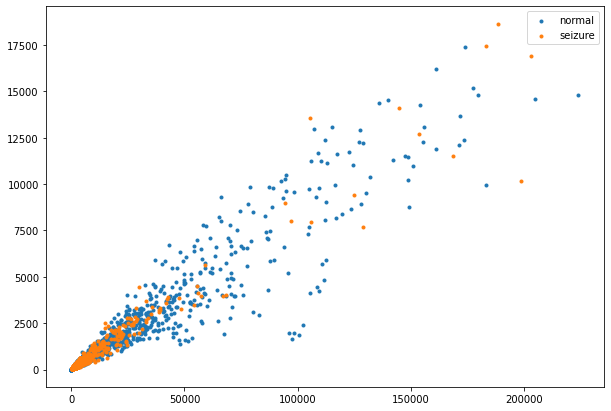

In [49]:
# %matplotlib inline
# import mpld3
# mpld3.enable_notebook()

d1 = data_max
d2 = data_mean

plt.figure(figsize=(10,7))

plt.scatter(
    x = d1[d1['label']=='normal']['value'],
    y = d2[d2['label']=='normal']['value'],
    marker = '.',
    label = 'normal')

plt.scatter(
    x = d1[d1['label']=='seizure']['value'],
    y = d2[d2['label']=='seizure']['value'],
    marker = '.',
    label = 'seizure')

# plt.margins(0,0.1)
plt.legend()


In [42]:
!pip install mpld3

     |████████████████████████████████| 1.0 MB 2.9 MB/s 
  Created wheel for mpld3: filename=mpld3-0.5.5-py3-none-any.whl size=200886 sha256=f68a6728e3a88ded1545b55129413cce7ed5153dafcbd119b1dff31f5cf908a5
  Stored in directory: /home/davi/.cache/pip/wheels/f3/62/17/5a58a3f9d3469ab204cf1d1e29510f39617e1a966db0493a21
Successfully built mpld3
